# 도구 호출 에이전트(Tool Calling Agent)

도구 호출을 사용하면 모델이 하나 이상의 **도구(tool)** 가 **호출되어야 하는 시기를 감지하고 해당 도구에 전달해야 하는 입력** 으로 전달할 수 있습니다. 

API 호출에서 도구를 설명하고 모델이 이러한 도구를 호출하기 위한 인수가 포함된 JSON과 같은 구조화된 객체를 출력하도록 지능적으로 선택할 수 있습니다. 

도구 API 의 목표는 일반 텍스트 완성이나 채팅 API를 사용하여 수행할 수 있는 것보다 더 안정적으로 유효하고 유용한 **도구 호출(tool call)** 을 반환하는 것입니다.

이러한 구조화된 출력을 도구 호출 채팅 모델에 여러 도구를 바인딩하고 모델이 호출할 도구를 선택할 수 있다는 사실과 결합하여 쿼리가 해결될 때까지 반복적으로 도구를 호출하고 결과를 수신하는 에이전트를 만들 수 있습니다.

이것은 OpenAI 의 특정 도구 호출 스타일에 맞게 설계된 OpenAI 도구 에이전트의 보다 **일반화된 버전** 입니다.

 이 에이전트는 LangChain의 ToolCall 인터페이스를 사용하여 OpenAI 외에도 `Anthropic`, `Google Gemini`, `Mistral`과 같은 더 광범위한 공급자 구현을 지원합니다.

**참고 링크**

- [LangChain 공식 도큐먼트](https://python.langchain.com/v0.1/docs/modules/agents/agent_types/tool_calling/)

In [1]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

True

In [2]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("CH15-Agents")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH15-Agents


In [3]:
from langchain.tools import tool
from typing import List, Dict, Annotated
from langchain_teddynote.tools import GoogleNews
from langchain_experimental.utilities import PythonREPL


# 도구 생성
@tool
def search_news(query: str) -> List[Dict[str, str]]:
    """Search Google News by input keyword"""
    news_tool = GoogleNews()
    return news_tool.search_by_keyword(query, k=5)


# 도구 생성
@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    result = ""
    try:
        result = PythonREPL().run(code)
    except BaseException as e:
        print(f"Failed to execute. Error: {repr(e)}")
    finally:
        return result


print(f"도구 이름: {search_news.name}")
print(f"도구 설명: {search_news.description}")
print(f"도구 이름: {python_repl_tool.name}")
print(f"도구 설명: {python_repl_tool.description}")

도구 이름: search_news
도구 설명: Search Google News by input keyword
도구 이름: python_repl_tool
도구 설명: Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user.


In [4]:
# tools 정의
tools = [search_news, python_repl_tool]

## Agent 프롬프트 생성

- `chat_history` : 이전 대화 내용을 저장하는 변수 (멀티턴을 지원하지 않는다면, 생략 가능합니다.)
- `agent_scratchpad` : 에이전트가 임시로 저장하는 변수
- `input` : 사용자의 입력

In [5]:
from langchain_core.prompts import ChatPromptTemplate

# 프롬프트 생성
# 프롬프트는 에이전트에게 모델이 수행할 작업을 설명하는 텍스트를 제공합니다. (도구의 이름과 역할을 입력)
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant. "
            "Make sure to use the `search_news` tool for searching keyword related news.",
        ),
        ("placeholder", "{chat_history}"),
        ("human", "{input}"),
        ("placeholder", "{agent_scratchpad}"),
    ]
)

## Agent 생성

In [6]:
from langchain_openai import ChatOpenAI
from langchain.agents import create_tool_calling_agent

# LLM 정의
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Agent 생성
agent = create_tool_calling_agent(llm, tools, prompt)

## AgentExecutor

AgentExecutor는 도구를 사용하는 에이전트를 실행하는 클래스입니다.

**주요 속성**
- `agent`: 실행 루프의 각 단계에서 계획을 생성하고 행동을 결정하는 에이전트
- `tools`: 에이전트가 사용할 수 있는 유효한 도구 목록
- `return_intermediate_steps`: 최종 출력과 함께 에이전트의 중간 단계 경로를 반환할지 여부
- `max_iterations`: 실행 루프를 종료하기 전 최대 단계 수
- `max_execution_time`: 실행 루프에 소요될 수 있는 최대 시간
- `early_stopping_method`: 에이전트가 `AgentFinish`를 반환하지 않을 때 사용할 조기 종료 방법. ("force" or "generate")
  - `"force"` 는 시간 또는 반복 제한에 도달하여 중지되었다는 문자열을 반환합니다.
  - `"generate"` 는 에이전트의 LLM 체인을 마지막으로 한 번 호출하여 이전 단계에 따라 최종 답변을 생성합니다.
- `handle_parsing_errors`: 에이전트의 출력 파서에서 발생한 오류 처리 방법. (True, False, 또는 오류 처리 함수)
- `trim_intermediate_steps`: 중간 단계를 트리밍하는 방법. (-1 trim 하지 않음, 또는 트리밍 함수)

**주요 메서드**
1. `invoke`: 에이전트 실행
2. `stream`: 최종 출력에 도달하는 데 필요한 단계를 스트리밍

**주요 기능**
1. **도구 검증**: 에이전트와 호환되는 도구인지 확인
2. **실행 제어**: 최대 반복 횟수 및 실행 시간 제한 설정 가능
3. **오류 처리**: 출력 파싱 오류에 대한 다양한 처리 옵션 제공
4. **중간 단계 관리**: 중간 단계 트리밍 및 반환 옵션
5. **비동기 지원**: 비동기 실행 및 스트리밍 지원

**최적화 팁**
- `max_iterations`와 `max_execution_time`을 적절히 설정하여 실행 시간 관리
- `trim_intermediate_steps`를 활용하여 메모리 사용량 최적화
- 복잡한 작업의 경우 `stream` 메서드를 사용하여 단계별 결과 모니터링

In [7]:
from langchain.agents import AgentExecutor

# AgentExecutor 생성
agent_executor = AgentExecutor(
    agent=agent,
    tools=tools,
    verbose=True,
    max_iterations=10,
    max_execution_time=10,
    handle_parsing_errors=True,
)

# AgentExecutor 실행
result = agent_executor.invoke({"input": "AI 투자와 관련된 뉴스를 검색해 주세요."})

print("Agent 실행 결과:")
print(result["output"])



> Entering new AgentExecutor chain...

Invoking: `search_news` with `{'query': 'AI 투자'}`


[{'url': 'https://news.google.com/rss/articles/CBMiS0FVX3lxTE51YlpldHRJY3JiQld5aTB2WDNYQXFUVmhaeGFkbE1ybERvZWE5QW5qOEt6MS10R3RFR0tBSHFDZWttazJPUjJzeVRzNA?oc=5', 'content': 'AI 투자 늘리는 통신사, 주파수 재할당 대가 마련 부담 - 전자신문'}, {'url': 'https://news.google.com/rss/articles/CBMiU0FVX3lxTFB1VDRjTlIxeHRjV3NKaERHMFJLOFNpUlNUVnZzQ0JvOUpISVE2cW9rbTZPVU9lQXZuUURJNHF0aDZyaDdQM0F5NFhsc0NrN1dHNEZz?oc=5', 'content': '글로벌 CEO들 "향후 3년 무조건 AI 투자···직원도 더 뽑을 것" - 네이트 뉴스'}, {'url': 'https://news.google.com/rss/articles/CBMiakFVX3lxTE9BQUtjd3pDS1dXRkZQTlo4Y2w2d2laZFFQRXdsbGlCMFRTcWJYLTNLaksxbFlnYzk3clVnYlFxZF93U2xubXY1VVhBTDQ2SDhLbm9hcDdXQ3prTlJtV0VCYTFINmNRbjR5N3c?oc=5', 'content': 'MIT 경제학자 "10년간 AI에 영향받을 직업은 5% 불과...기업은 투자비만 날리게 될 것" - AI타임스'}, {'url': 'https://news.google.com/rss/articles/CBMiW0FVX3lxTE9oenZObVAzOV9hbUliNGhkLTBXZXZrTGpvT0ljcXlpWE5leld2b3RLbUJFTFRtZnU4c0VFaC1oYkVvTTdESEZCYmZUTDJSMFFYdGVXeXN3OVdRTEE?oc=5',

## Stream 출력으로 단계별 결과 확인

AgentExecutor의 `stream()` 메소드를 사용하여 에이전트의 중간 단계를 스트리밍할 것입니다.

`stream()`의 출력은 (Action, Observation) 쌍 사이에서 번갈아 나타나며, 최종적으로 에이전트가 목표를 달성했다면 답변으로 마무리됩니다.

다음과 같은 형태로 보일 것입니다.

1. Action 출력
2. Observation 출력
3. Action 출력
4. Observation 출력

... (목표 달성까지 계속) ...

그 다음, 최종 목표가 달성되면 에이전트는 최종 답변을 출력할 것입니다.

이러한 출력의 내용은 다음과 같이 요약됩니다.

| 출력 | 내용 |
|--------|----------|
| Action | `actions`: AgentAction 또는 그 하위 클래스<br>`messages`: 액션 호출에 해당하는 채팅 메시지 |
| Observation | `steps`: 현재 액션과 그 관찰을 포함한 에이전트가 지금까지 수행한 작업의 기록<br>`messages`: 함수 호출 결과(즉, 관찰)를 포함한 채팅 메시지 |
| Final Answer | `output`: AgentFinish<br>`messages`: 최종 출력을 포함한 채팅 메시지 |
```

In [8]:
from langchain.agents import AgentExecutor

# AgentExecutor 생성
agent_executor = AgentExecutor(
    agent=agent,
    tools=tools,
    verbose=False,
    handle_parsing_errors=True,
)

In [9]:
# 스트리밍 모드로 실행합니다
result = agent_executor.stream({"input": "AI 투자와 관련된 뉴스를 검색해 주세요."})

for step in result:
    # 중간 단계 출력
    print(step)

{'actions': [ToolAgentAction(tool='search_news', tool_input={'query': 'AI 투자'}, log="\nInvoking: `search_news` with `{'query': 'AI 투자'}`\n\n\n", message_log=[AIMessageChunk(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_dWv4C6NpksKE1IyaVmXjuDtT', 'function': {'arguments': '{"query":"AI 투자"}', 'name': 'search_news'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_f85bea6784'}, id='run-75795ef1-9b6b-4733-9dff-009486316af6', tool_calls=[{'name': 'search_news', 'args': {'query': 'AI 투자'}, 'id': 'call_dWv4C6NpksKE1IyaVmXjuDtT', 'type': 'tool_call'}], tool_call_chunks=[{'name': 'search_news', 'args': '{"query":"AI 투자"}', 'id': 'call_dWv4C6NpksKE1IyaVmXjuDtT', 'index': 0, 'type': 'tool_call_chunk'}])], tool_call_id='call_dWv4C6NpksKE1IyaVmXjuDtT')], 'messages': [AIMessageChunk(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_dWv4C6NpksKE1IyaVmXjuDtT', 'func

### 중간 단계 출력을 사용자 정의 함수로 출력

다음의 3개 함수를 정의하고 이를 통해 중간 단계 출력을 사용자 정의합니다.

- `tool_callback`: 도구 호출 출력을 처리하는 함수
- `observation_callback`: 관찰(Observation) 출력을 처리하는 함수
- `result_callback`: 최종 답변 출력을 처리하는 함수

In [10]:
# 업데이트
# !pip install -U langchain-teddynote

아래는 Agent 의 중간 단계 과정을 깔끔하게 출력하기 위하여 사용되는 콜백 함수입니다.

이 콜백 함수는 Streamlit 에서 중간 단계를 출력하여 사용자에게 제공할 때 유용할 수 있습니다.

In [11]:
from langchain_teddynote.messages import AgentStreamParser

agent_stream_parser = AgentStreamParser()

스트리밍 방식으로 Agent 의 응답 과정을 확인합니다.

Python REPL can execute arbitrary code. Use with caution.


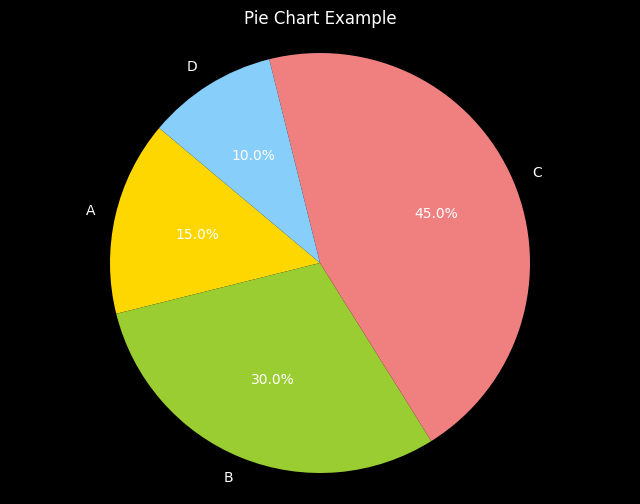

[도구 호출]
Tool: python_repl_tool
code: import matplotlib.pyplot as plt

# 데이터
sizes = [15, 30, 45, 10]
labels = ['A', 'B', 'C', 'D']
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']

# 파이 차트 그리기
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Pie Chart Example')
plt.show()
Log: 
Invoking: `python_repl_tool` with `{'code': "import matplotlib.pyplot as plt\n\n# 데이터\nsizes = [15, 30, 45, 10]\nlabels = ['A', 'B', 'C', 'D']\ncolors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']\n\n# 파이 차트 그리기\nplt.figure(figsize=(8, 6))\nplt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)\nplt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.\nplt.title('Pie Chart Example')\nplt.show()"}`



[관찰 내용]
Observation: 
[최종 답변]
파이 차트가 성공적으로 그려졌습니다. 차트에는 A, B, C, D의 네 가지 카테고리가 포함되어 있으며, 각 카테고리의 비

In [12]:
# 질의에 대한 답변을 스트리밍으로 출력 요청
result = agent_executor.stream(
    {"input": "matplotlib 을 사용하여 pie 차트를 그리는 코드를 작성하고 실행하세요."}
)

for step in result:
    # 중간 단계를 parser 를 사용하여 단계별로 출력
    agent_stream_parser.process_agent_steps(step)

다음은 callback 을 수정하여 사용하는 방법입니다.

In [15]:
# AgentCallbacks와 AgentStreamParser를 langchain_teddynote.messages에서 가져옵니다.
from langchain_teddynote.messages import AgentCallbacks, AgentStreamParser


# 도구 호출 시 실행되는 콜백 함수입니다.
def tool_callback(tool) -> None:
    print("<<<<<<< 도구 호출 >>>>>>")
    print(f"Tool: {tool.get('tool')}")  # 사용된 도구의 이름을 출력합니다.
    print("<<<<<<< 도구 호출 >>>>>>")


# 관찰 결과를 출력하는 콜백 함수입니다.
def observation_callback(observation) -> None:
    print("<<<<<<< 관찰 내용 >>>>>>")
    print(
        f"Observation: {observation.get('observation')[0]}"
    )  # 관찰 내용을 출력합니다.
    print("<<<<<<< 관찰 내용 >>>>>>")


# 최종 결과를 출력하는 콜백 함수입니다.
def result_callback(result: str) -> None:
    print("<<<<<<< 최종 답변 >>>>>>")
    print(result)  # 최종 답변을 출력합니다.
    print("<<<<<<< 최종 답변 >>>>>>")


# AgentCallbacks 객체를 생성하여 각 단계별 콜백 함수를 설정합니다.
agent_callbacks = AgentCallbacks(
    tool_callback=tool_callback,
    observation_callback=observation_callback,
    result_callback=result_callback,
)

# AgentStreamParser 객체를 생성하여 에이전트의 실행 과정을 파싱합니다.
agent_stream_parser = AgentStreamParser(agent_callbacks)

아래의 출력 내용을 확인해 보면 중간 내용의 출력 값이 내가 변경한 콜백 함수의 출력 값으로 변경된 것을 확인할 수 있습니다.

In [16]:
# 질의에 대한 답변을 스트리밍으로 출력 요청
result = agent_executor.stream({"input": "AI 투자관련 뉴스를 검색해 주세요."})

for step in result:
    # 중간 단계를 parser 를 사용하여 단계별로 출력
    agent_stream_parser.process_agent_steps(step)

<<<<<<< 도구 호출 >>>>>>
Tool: search_news
<<<<<<< 도구 호출 >>>>>>
<<<<<<< 관찰 내용 >>>>>>
Observation: {'url': 'https://news.google.com/rss/articles/CBMiS0FVX3lxTE51YlpldHRJY3JiQld5aTB2WDNYQXFUVmhaeGFkbE1ybERvZWE5QW5qOEt6MS10R3RFR0tBSHFDZWttazJPUjJzeVRzNA?oc=5', 'content': 'AI 투자 늘리는 통신사, 주파수 재할당 대가 마련 부담 - 전자신문'}
<<<<<<< 관찰 내용 >>>>>>
<<<<<<< 최종 답변 >>>>>>
다음은 AI 투자와 관련된 최근 뉴스 기사들입니다:

1. [AI 투자 늘리는 통신사, 주파수 재할당 대가 마련 부담 - 전자신문](https://news.google.com/rss/articles/CBMiS0FVX3lxTE51YlpldHRJY3JiQld5aTB2WDNYQXFUVmhaeGFkbE1ybERvZWE5QW5qOEt6MS10R3RFR0tBSHFDZWttazJPUjJzeVRzNA?oc=5)

2. [글로벌 CEO들 "향후 3년 무조건 AI 투자···직원도 더 뽑을 것" - 네이트 뉴스](https://news.google.com/rss/articles/CBMiU0FVX3lxTFB1VDRjTlIxeHRjV3NKaERHMFJLOFNpUlNUVnZzQ0JvOUpISVE2cW9rbTZPVU9lQXZuUURJNHF0aDZyaDdQM0F5NFhsc0NrN1dHNEZz?oc=5)

3. [MIT 경제학자 "10년간 AI에 영향받을 직업은 5% 불과...기업은 투자비만 날리게 될 것" - AI타임스](https://news.google.com/rss/articles/CBMiakFVX3lxTE9BQUtjd3pDS1dXRkZQTlo4Y2w2d2laZFFQRXdsbGlCMFRTcWJYLTNLaksxbFlnYzk3clVnYlFxZF93U2xubXY1VVhBTDQ

## 이전 대화내용 기억하는 Agent

이전의 대화내용을 기억하기 위해서는 `RunnableWithMessageHistory` 를 사용하여 `AgentExecutor` 를 감싸줍니다.

`RunnableWithMessageHistory` 에 대한 자세한 내용은 아래 링크를 참고해 주세요.

**참고**
- [RunnableWithMessageHistory](https://wikidocs.net/254682)

In [17]:
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory

# session_id 를 저장할 딕셔너리 생성
store = {}


# session_id 를 기반으로 세션 기록을 가져오는 함수
def get_session_history(session_ids):
    if session_ids not in store:  # session_id 가 store에 없는 경우
        # 새로운 ChatMessageHistory 객체를 생성하여 store에 저장
        store[session_ids] = ChatMessageHistory()
    return store[session_ids]  # 해당 세션 ID에 대한 세션 기록 반환


# 채팅 메시지 기록이 추가된 에이전트를 생성합니다.
agent_with_chat_history = RunnableWithMessageHistory(
    agent_executor,
    # 대화 session_id
    get_session_history,
    # 프롬프트의 질문이 입력되는 key: "input"
    input_messages_key="input",
    # 프롬프트의 메시지가 입력되는 key: "chat_history"
    history_messages_key="chat_history",
)

In [18]:
# 질의에 대한 답변을 스트리밍으로 출력 요청
response = agent_with_chat_history.stream(
    {"input": "안녕? 내 이름은 테디야!"},
    # session_id 설정
    config={"configurable": {"session_id": "abc123"}},
)

# 출력 확인
for step in response:
    agent_stream_parser.process_agent_steps(step)

<<<<<<< 최종 답변 >>>>>>
안녕하세요, 테디! 만나서 반가워요. 어떻게 도와드릴까요?
<<<<<<< 최종 답변 >>>>>>


In [19]:
# 질의에 대한 답변을 스트리밍으로 출력 요청
response = agent_with_chat_history.stream(
    {"input": "내 이름이 뭐라고?"},
    # session_id 설정
    config={"configurable": {"session_id": "abc123"}},
)

# 출력 확인
for step in response:
    agent_stream_parser.process_agent_steps(step)

<<<<<<< 최종 답변 >>>>>>
당신의 이름은 테디입니다!
<<<<<<< 최종 답변 >>>>>>


In [20]:
# 질의에 대한 답변을 스트리밍으로 출력 요청
response = agent_with_chat_history.stream(
    {
        "input": "내 이메일 주소는 teddy@teddynote.com 이야. 회사 이름은 테디노트 주식회사야."
    },
    # session_id 설정
    config={"configurable": {"session_id": "abc123"}},
)

# 출력 확인
for step in response:
    agent_stream_parser.process_agent_steps(step)

<<<<<<< 최종 답변 >>>>>>
감사합니다, 테디! 테디노트 주식회사에 대해 더 알고 싶으신가요? 아니면 다른 도움이 필요하신가요?
<<<<<<< 최종 답변 >>>>>>


In [21]:
# 질의에 대한 답변을 스트리밍으로 출력 요청
response = agent_with_chat_history.stream(
    {
        "input": "최신 뉴스 5개를 검색해서 이메일의 본문으로 작성해줘. "
        "수신인에는 `셜리 상무님` 그리고, 발신인에는 내 인적정보를 적어줘."
        "정중한 어조로 작성하고, 메일의 시작과 끝에는 적절한 인사말과 맺음말을 적어줘."
    },
    # session_id 설정
    config={"configurable": {"session_id": "abc123"}},
)

# 출력 확인
for step in response:
    agent_stream_parser.process_agent_steps(step)

<<<<<<< 도구 호출 >>>>>>
Tool: search_news
<<<<<<< 도구 호출 >>>>>>
<<<<<<< 관찰 내용 >>>>>>
Observation: {'url': 'https://news.google.com/rss/articles/CBMiakFVX3lxTFB6b3FPREFINURLSy1pVUZDbXB4X3JwaW1fVGNCRks1RklJMDFNTWxCbURTbGMwU05kWVRRLU9xNnVFUkNPVFNLaUlTOThQaDRoQzlKQWtsQnVETnFqbEhGc2hIQnU2RERoS3c?oc=5', 'content': '인사이드 구글 - The Keyword'}
<<<<<<< 관찰 내용 >>>>>>
<<<<<<< 최종 답변 >>>>>>
아래는 셜리 상무님께 보낼 이메일 본문입니다.

---

제목: 최신 뉴스 업데이트

안녕하세요, 셜리 상무님.

테디노트 주식회사의 테디입니다. 최근의 주요 뉴스를 아래와 같이 정리하여 전달드립니다.

1. [인사이드 구글 - The Keyword](https://news.google.com/rss/articles/CBMiakFVX3lxTFB6b3FPREFINURLSy1pVUZDbXB4X3JwaW1fVGNCRks1RklJMDFNTWxCbURTbGMwU05kWVRRLU9xNnVFUkNPVFNLaUlTOThQaDRoQzlKQWtsQnVETnFqbEhGc2hIQnU2RERoS3c?oc=5)
   
2. [지역별 가격 조정 예고 - Riot Games](https://news.google.com/rss/articles/CBMickFVX3lxTE9USmRUM2lXX0NkdXgwdWlYMk1MQnprMmEwT3UySUd0MFg1VTJzQldNMGNXVEw4N0VvUlJDaklEX2Vybl9QcGIwTGwyNzhYeS1sVkJmSDRDbDliRm9FOWRpMlJiM0FrWDBsb0RCeExKTVhYZw?oc=5)

3. ['제135회 중국수출입박람회' 광저우서 개막 - 최신 뉴스 온라인 선전시 정부](https://